In [ ]:
!pip install xgboost scikit-learn pandas matplotlib

In [ ]:
import kagglehub
import pandas as pd
import os
path1 = kagglehub.dataset_download("ayoubjadouli/morocco-wildfire-predictions-2010-2022-ml-dataset") #Dataset จาก Jadouli, A. (2023). *Morocco Wildfire Predictions (2010-2022) ML Dataset* [Data set]. Kaggle. https://www.kaggle.com/datasets/ayoubjadouli/morocco-wildfire-predictions-2010-2022-ml-dataset
file_path = os.path.join(path1, 'Date_final_dataset_balanced_float32.parquet')
df = pd.read_parquet(file_path)
df = df.head(20000)

100%|██████████| 199M/199M [00:01<00:00, 187MB/s]

Extracting files...


In [ ]:
df = df[['latitude','longitude','NDVI','average_temperature_lag_1', 'precipitation_lag_1','dew_point_lag_1','wind_speed_lag_1','is_fire','acq_date']].rename(columns={
    'average_temperature_lag_1': 'Temperature',
    'precipitation_lag_1': 'Precipitation',
    'dew_point_lag_1': 'Humidity',
    'wind_speed_lag_1': 'Windspeed',
    'acq_date': 'Date'})
df["Temperature"] = (df["Temperature"] - 32) * 5.0/9.0
df.rename(columns={"Temperature": "Temperature"}, inplace=True)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df = df.drop('Date', axis=1)

print(df.head())

    latitude  longitude    NDVI  Temperature  Precipitation   Humidity  \
0  31.390602  -4.254445  1139.0    23.055555            0.0  41.599998   
1  33.832943  -5.188356  3223.0     7.333333            0.0  34.299999   
2  35.385689  -5.684218  4987.0    18.055555            0.0  54.099998   
3  30.122351  -7.498038   991.0    24.555553            0.0  23.799999   
4  30.221554  -9.154314  2171.0    25.888889            0.0  46.299999   

   Windspeed  is_fire  Year  Month  Day  
0   6.200000      1.0  2015      5   28  
1   5.400000      1.0  2017     12    5  
2  21.299999      1.0  2021     11   19  
3   3.500000      0.0  2014      4   19  
4   8.100000      1.0  2014      4   11  


Accuracy: 0.8936666666666667
[[1310  195]
 [ 124 1371]]
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      1505
         1.0       0.88      0.92      0.90      1495

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



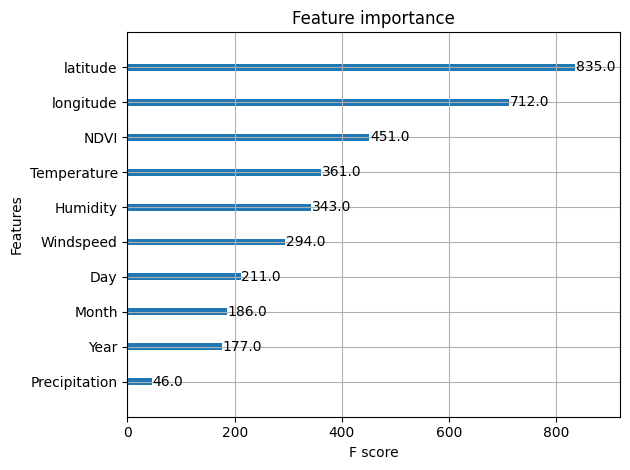

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


# Feature columns (replace with your actual feature names)
features = ['Temperature', 'latitude','longitude','Humidity', 'Precipitation', 'Windspeed', 'NDVI', 'Year','Month','Day']
target = 'is_fire'  # Binary target: 0 = No fire, 1 = Fire

X = df[features]
y = df[target]

# Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DMatrix for XGBoost (optional, but useful)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set model parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'seed': 42
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance plot
xgb.plot_importance(bst)
plt.tight_layout()
plt.show()

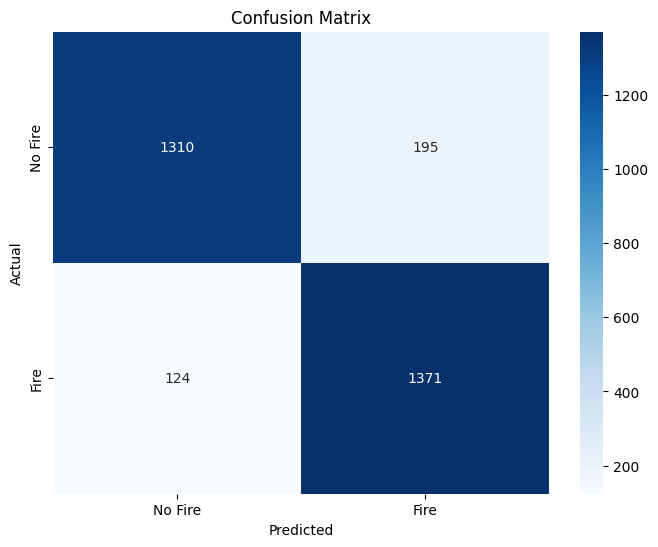

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()